In [2]:
#!g1.2
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/15/95/951b51229a9c8af767e48b1f9ef7baa87279b1f5847d2f85de0855578e5d/catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [8]:
#!g1.2
%pip install fancyimpute 


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for setuptools>65.5.1 from https://files.pythonhosted.org/packages/bb/e1/ed2dd0850446b8697ad28d118df885ad04140c64ace06c4bd559f7c8a94f/setuptools-69.0.2-py3-none-any.whl.metadata
  Using cached setuptools-69.0.2-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-69.0.2-py3-none-any.whl (819 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-kernel 0.0.1 requires requests>=2.31.0, but you have requests 2.27.1 which is incompatible.
ml-kernel 0.0.1 requires setuptools<=51.0.0, but you have setuptools 69.0.2 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [355]:
#!g1.2
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [354]:
#!g1.2
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [366]:
#!g1.2

train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [367]:
#!g1.2

y1 = train_df.target_1
y2 = train_df.target_2

In [368]:
#!g1.2

train_df.drop(["id", "target_1", "target_2"], axis=1, inplace=True)
test_df.drop(["id"], axis=1, inplace=True)

# Обработка данных

In [369]:
#!g1.2

cat_cols = [
    'channel_code', 'city', 'city_type',
    'index_city_code', 'ogrn_month', 'ogrn_year',
    'branch_code', 'okved', 'segment', 'has_non_fin_deals'
]

In [370]:
#!g1.2

def data_transform(X):
    X['has_non_fin_deals'] = (X['max_end_plan_non_fin_deals'].isna() == False)
    X[cat_cols] = X[cat_cols].astype("category")
    for i in cat_cols:
        X.loc[X[i].isna(), i] = X[i].mode()[0]
    num_cols = X.columns.difference(X[cat_cols].columns).drop(['cnt_b_oper_3m'])
    X[num_cols] = X[num_cols].fillna(0)
    X[num_cols] = X[num_cols].astype("int64")
    for i in X[num_cols]:
        X.loc[X[i] < 0, i] = np.nan
    X.loc[(X['balance_amt_max'] < X['balance_amt_min']), 'balance_amt_min']  = np.nan
    X.loc[(X['balance_amt_max'] < X['balance_amt_avg']),  'balance_amt_avg'] = np.nan
    for i in num_cols:
      if 'balance' in i or 'sum_' in i:
        X[i] = np.log1p(X[i])
    return X

In [371]:
#!g1.2
#!g1.2
X = train_df.drop("total_target", axis=1)
y = train_df.total_target

In [372]:
#!g1.2

X = data_transform(X)

In [373]:

#!g1.2
test_df = data_transform(test_df)

In [374]:
#!g1.2
numeric_data = X.select_dtypes([np.number])
num_cols = numeric_data.columns

In [375]:
#!g1.2
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
from sklearn.impute import IterativeImputer

X_imputed = X
X_imputed[num_cols] = SoftImpute().fit_transform(X[num_cols].to_numpy())

test_df_imputed = test_df
test_df_imputed[num_cols] = SoftImpute().fit_transform(test_df[num_cols].to_numpy())

[SoftImpute] Max Singular Value of X_init = 24970371.577748
[SoftImpute] Iter 1: observed MAE=30.819824 rank=16
[SoftImpute] Iter 2: observed MAE=30.819650 rank=16
[SoftImpute] Iter 3: observed MAE=30.819635 rank=16
[SoftImpute] Iter 4: observed MAE=30.819630 rank=16
[SoftImpute] Iter 5: observed MAE=30.819628 rank=16
[SoftImpute] Iter 6: observed MAE=30.819628 rank=16
[SoftImpute] Iter 7: observed MAE=30.819627 rank=16
[SoftImpute] Iter 8: observed MAE=30.819627 rank=16
[SoftImpute] Stopped after iteration 8 for lambda=499407.431555
[SoftImpute] Max Singular Value of X_init = 1145869.583224
[SoftImpute] Iter 1: observed MAE=7.248715 rank=8
[SoftImpute] Iter 2: observed MAE=7.248642 rank=8
[SoftImpute] Iter 3: observed MAE=7.248642 rank=8
[SoftImpute] Stopped after iteration 3 for lambda=22917.391664



## Новые фичи

In [376]:
#!g1.2
X_imputed['balance_amt_deviation'] = np.abs((X_imputed['balance_amt_max'] - X_imputed['balance_amt_min']) / 2 - X_imputed['balance_amt_day_avg'])
X_imputed['founderpres_difference'] = X_imputed['max_founderpres'] - X_imputed['min_founderpres']
X_imputed['a_oper_1m_avg'] = np.where((X_imputed['cnt_a_oper_1m'] >= 1), (X_imputed['sum_a_oper_1m'] / X_imputed['cnt_a_oper_1m']), X_imputed['sum_a_oper_1m'])
X_imputed['avg_start_non_fin_deals_difference'] = (X_imputed['min_start_non_fin_deals'] - X_imputed['max_start_non_fin_deals'])  / 2
X_imputed['avg_end_fact_fin_deals'] = (X_imputed['min_end_fact_fin_deals'] - X_imputed['max_end_fact_fin_deals'])  / 2
X_imputed['avg_end_plan_non_fin_deals'] = (X_imputed['min_end_plan_non_fin_deals'] - X_imputed['max_end_plan_non_fin_deals'])  / 2
X_imputed['avg_non_fin_difference'] = X_imputed['avg_start_non_fin_deals_difference'] - X_imputed['avg_end_plan_non_fin_deals']

X_imputed['sum_cred_e_oper_1m**3*sum_cred_e_oper_3m**3'] = (X_imputed['sum_cred_e_oper_1m']**3)*(X_imputed['sum_cred_e_oper_3m']**3)

X_imputed['balance_amt_max**3*balance_amt_min'] = (X_imputed['balance_amt_max'] ** 3) * (X_imputed['balance_amt_min'])
X_imputed['balance_amt_day_avg*balance_amt_max**2'] = (X_imputed['balance_amt_day_avg']) * (X_imputed['balance_amt_max']**2)
X_imputed['balance_amt_avg**2*balance_amt_max**3'] = (X_imputed['balance_amt_avg']**2) * (X_imputed['balance_amt_max']**3)

<ipython-input-219-10bc6f73e138>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_imputed['balance_amt_avg**2*balance_amt_max**3'] = (X_imputed['balance_amt_avg']**2) * (X_imputed['balance_amt_max']**3)


In [377]:
#!g1.2
test_df_imputed['balance_amt_deviation'] = np.abs((test_df_imputed['balance_amt_max'] - test_df_imputed['balance_amt_min']) / 2 - test_df_imputed['balance_amt_day_avg'])
test_df_imputed['founderpres_difference'] = test_df_imputed['max_founderpres'] - test_df_imputed['min_founderpres']
test_df_imputed['a_oper_1m_avg'] = np.where((test_df_imputed['cnt_a_oper_1m'] >= 1), (test_df_imputed['sum_a_oper_1m'] / test_df_imputed['cnt_a_oper_1m']), test_df_imputed['sum_a_oper_1m'])
test_df_imputed['avg_start_non_fin_deals_difference'] = (test_df_imputed['min_start_non_fin_deals'] - test_df_imputed['max_start_non_fin_deals'])  / 2
test_df_imputed['avg_end_fact_fin_deals'] = (test_df_imputed['min_end_fact_fin_deals'] - test_df_imputed['max_end_fact_fin_deals'])  / 2
test_df_imputed['avg_end_plan_non_fin_deals'] = (test_df_imputed['min_end_plan_non_fin_deals'] - test_df_imputed['max_end_plan_non_fin_deals'])  / 2
test_df_imputed['avg_non_fin_difference'] = test_df_imputed['avg_start_non_fin_deals_difference'] - test_df_imputed['avg_end_plan_non_fin_deals']

test_df_imputed['sum_cred_e_oper_1m**3*sum_cred_e_oper_3m**3'] = (test_df_imputed['sum_cred_e_oper_1m']**3)*(test_df_imputed['sum_cred_e_oper_3m']**3)

test_df_imputed['balance_amt_max**3*balance_amt_min'] = (test_df_imputed['balance_amt_max'] ** 3) * (test_df_imputed['balance_amt_min'])
test_df_imputed['balance_amt_day_avg*balance_amt_max**2'] = (test_df_imputed['balance_amt_day_avg']) * (test_df_imputed['balance_amt_max']**2)
test_df_imputed['balance_amt_avg**2*balance_amt_max**3'] = (test_df_imputed['balance_amt_avg']**2) * (test_df_imputed['balance_amt_max']**3)

<ipython-input-220-fbeb4fb869af>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_imputed['balance_amt_avg**2*balance_amt_max**3'] = (test_df_imputed['balance_amt_avg']**2) * (test_df_imputed['balance_amt_max']**3)


### Три модели

In [378]:
#!g1.2
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

In [379]:
#!g1.2
catboost_params = {
    'iterations': 2000,
    'loss_function': 'Logloss',
    'task_type': 'GPU',
    'eval_metric': 'AUC',
    'random_seed': 42,
    'od_type': 'Iter',
    'early_stopping_rounds': 300,
    'learning_rate': 0.03,
    'depth': 10,
    'random_strength': 0.5,
    'verbose': 100,
}

xgb_params = {
    'n_estimators': 1000,
    'n_job': 6,
    'max_depth': 8,
    'learning_rate': 0.05,
    'colsample_bytree': 0.5,
    'tree_method': 'gpu_hist', 
    'enable_categorical':True,
    "device":"cuda"
}

lgb_params = {
    'n_estimators': 2500,
    'learning_rate': 0.05,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_lambda': 0.2
}

In [380]:
#!g1.2

train_x, val_x, train_y, val_y = train_test_split(X, y, shuffle=False)

In [382]:
#!g1.2
import os
import zipfile
from IPython.display import FileLink

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

def eval_recorder(params, tep, teprob, trp, trprob, scores, fi, name, mode='local'):
    scores = pd.DataFrame(scores, columns=['score'])
    mean_score = round(scores['score'].mean(), 6)
    std_score = round(scores['score'].std(), 4)
    name_score = str(mean_score) + '_' + str(std_score)
    if mode == 'local':
        if not os.path.isdir('results/' + name + '_' + name_score):
            os.mkdir('results/' + name + '_' + name_score)
        base_path = 'results/' + name + '_' + name_score + '/'
    
    pd.Series(params).to_csv(base_path + 'params.csv', index=False)
    pd.DataFrame(tep).to_csv(base_path + 'test_predictions.csv', index=False)
    pd.DataFrame(teprob).to_csv(base_path + 'test_probablity.csv', index=False)
    if trp is not None:
        pd.DataFrame({'predition': trp, 'probablity': trprob}).to_csv(base_path + 'train_results.csv')
    pd.DataFrame(fi).to_csv(base_path + 'feature_importances.csv', index=False)
    
def split_eval(train, labels, x_val, y_val, test, clf, params, fit_params, name):
    scores = []
    feature_importances = np.zeros(len(train.columns))
    test_predictions = np.zeros(test.shape[0])
    test_probablity = np.zeros(test.shape[0])
    
    clf.fit(train, labels, eval_set=[(x_val, y_val)], **fit_params)
    if 'catboost' in name:
        scores.append(clf.best_score_['validation']['AUC'])
    if 'xgboost' in name:
        try:
            scores.append(clf.best_score)
        except:
            scores.append({'valid_0': {'auc': clf.evals_result()['validation_0']['auc'][-1]}})
    if 'lightgbm' in name:
        scores.append(clf.best_score_)
    test_predicts = clf.predict_proba(test)
    test_predictions = test_predicts[:, 1]
    test_probablity = test_predicts[:, 0]
    feature_importances = clf.feature_importances_
    print('-'*60)
    if 'lightgbm' in name:
        scores = [dict(s)['valid_0']['auc'] for s in scores]
    del clf
    return test_predictions, test_probablity, None, None, scores, feature_importances, 'filename'

def plot_feature_importances(fe, cols):
    fe = pd.DataFrame(fe, index=cols)
    if fe.shape[1] > 1:
        fe = fe.apply(sum, axis=1)
    else:
        fe = fe[0]
    fe.sort_values(ascending=False)[:20].plot(kind='bar')

def cv_eval(train, labels, test, clf, cv, params, fit_params, name):
    scores = []
    feature_importances = np.zeros((len(train.columns), cv.n_splits))
    train_predictions = np.zeros(train.shape[0])
    train_probablity = np.zeros(train.shape[0])
    test_predictions = np.zeros((test.shape[0], cv.n_splits))
    test_probablity = np.zeros((test.shape[0], cv.n_splits))
    for i, (train_index, val_index) in enumerate(cv.split(train, labels)):
        print(f'starting {i} split')
        x_train = train.iloc[train_index]
        y_train = labels[train_index]
        x_val = train.iloc[val_index]
        y_val = labels[val_index]
        clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], **fit_params)
        if 'catboost' in name:
            scores.append(clf.best_score_['validation']['AUC'])
        if 'xgboost' in name:
            try:
                scores.append(clf.best_score)
            except:
                scores.append({'valid_0': {'auc': clf.evals_result()['validation_0']['auc'][-1]}})
        if 'lightgbm' in name:
            scores.append(clf.best_score_)
        val_predictions = clf.predict_proba(x_val)
        train_predictions[val_index] = val_predictions[:, 1]
        train_probablity[val_index] = val_predictions[:, 0]
        test_predicts = clf.predict_proba(test)
        test_predictions[:, i] = test_predicts[:, 1]
        test_probablity[:, i] = test_predicts[:, 0]
        feature_importances[:, i] = clf.feature_importances_
        print('-'*60)
        del clf
    filename = eval_recorder(params, test_predictions, test_probablity, train_predictions, train_probablity, scores, feature_importances, name, 'local')
    return test_predictions, test_probablity, train_predictions, train_probablity, scores, feature_importances, filename

def eval_catboost(train, labels, test, cv, params, cat_features, name, eval_set=None):
    clf = CatBoostClassifier(**params)
    fit_params = {
        'cat_features': cat_features,
        'plot':False
    }

    return split_eval(train, labels, eval_set[0], eval_set[1], test, clf, params, fit_params, 'catboost_' + name)

def eval_xgboost(train, labels, test, cv, params, name, eval_set=None):
    clf = XGBClassifier(**params)
    fit_params = {
        'verbose':100, 
        'eval_metric':'auc',
        'early_stopping_rounds': 300
    }
    if cv is not None:
        return cv_eval(train, labels, test, clf, cv, params, fit_params, 'xgboost_' + name)
    return split_eval(train, labels, eval_set[0], eval_set[1], test, clf, params, fit_params, 'xgboost_' + name)

def eval_lightgbm(train, labels, test, cv, params, cat_features, name, eval_set=None):
    clf = LGBMClassifier(**params)
    fit_params = {
        'verbose': 100,
        'eval_metric': 'auc',
        #'categorical_feature':cat_features,        
        'early_stopping_rounds': 300
    }
    if cv is not None:
        return cv_eval(train, labels, test, clf, cv, params, fit_params, 'lightgbm_' + name)
    return split_eval(train, labels, eval_set[0], eval_set[1], test, clf, params, fit_params, 'lightgbm_' + name)

In [383]:
#!g1.2
test_predictions_cat, test_probablity_cal, train_predictions, train_probablity, scores, feature_importances, result_zip = eval_catboost(
    train_x,
    train_y,
    test_df,
    None,
    catboost_params,
    cat_cols,
    'catboost_tts',
    (val_x, val_y)
)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8456061	best: 0.8456061 (0)	total: 83.8ms	remaining: 2m 47s
100:	test: 0.8799831	best: 0.8799831 (100)	total: 7.38s	remaining: 2m 18s
200:	test: 0.8874832	best: 0.8874832 (200)	total: 14.8s	remaining: 2m 12s
300:	test: 0.8918001	best: 0.8918001 (300)	total: 22.3s	remaining: 2m 6s
400:	test: 0.8960078	best: 0.8960078 (400)	total: 29.9s	remaining: 1m 59s
500:	test: 0.8995548	best: 0.8995548 (500)	total: 37.4s	remaining: 1m 51s
600:	test: 0.9025532	best: 0.9025532 (600)	total: 44.9s	remaining: 1m 44s
700:	test: 0.9054430	best: 0.9054430 (700)	total: 52.5s	remaining: 1m 37s
800:	test: 0.9076063	best: 0.9076063 (800)	total: 1m	remaining: 1m 29s
900:	test: 0.9100180	best: 0.9100180 (900)	total: 1m 7s	remaining: 1m 22s
1000:	test: 0.9121478	best: 0.9121478 (1000)	total: 1m 15s	remaining: 1m 15s
1100:	test: 0.9144148	best: 0.9144148 (1100)	total: 1m 23s	remaining: 1m 7s
1200:	test: 0.9160021	best: 0.9160021 (1200)	total: 1m 30s	remaining: 1m
1300:	test: 0.9178771	best: 0.9178771 (13

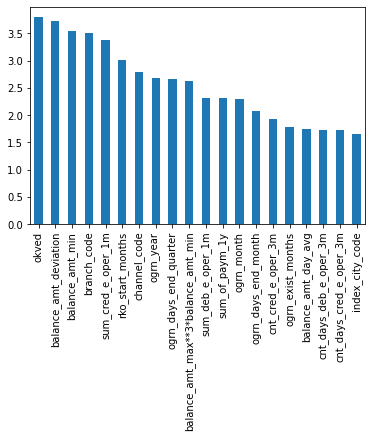

In [384]:
#!g1.2
plot_feature_importances(feature_importances, train_x.columns)

In [ ]:
#!g1.2


In [385]:
#!g1.2
test_predictions_lgb, test_probablity_lgb, train_predictions, train_probablity, scores, feature_importances, result_zip = eval_lightgbm(
    train_x,
    train_y,
    test_df,
    None,
    lgb_params,
    cat_cols,
    'lightgbm_tts',
    (val_x, val_y)
)

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param di

[100]	valid_0's auc: 0.898634	valid_0's binary_logloss: 0.165344
[200]	valid_0's auc: 0.910943	valid_0's binary_logloss: 0.157915
[300]	valid_0's auc: 0.918421	valid_0's binary_logloss: 0.152791
[400]	valid_0's auc: 0.923705	valid_0's binary_logloss: 0.148453
[500]	valid_0's auc: 0.927587	valid_0's binary_logloss: 0.14491
[600]	valid_0's auc: 0.930458	valid_0's binary_logloss: 0.141802
[700]	valid_0's auc: 0.932951	valid_0's binary_logloss: 0.13908
[800]	valid_0's auc: 0.935327	valid_0's binary_logloss: 0.136434
[900]	valid_0's auc: 0.93744	valid_0's binary_logloss: 0.133905
[1000]	valid_0's auc: 0.938829	valid_0's binary_logloss: 0.131856
[1100]	valid_0's auc: 0.940325	valid_0's binary_logloss: 0.129778
[1200]	valid_0's auc: 0.941505	valid_0's binary_logloss: 0.127929
[1300]	valid_0's auc: 0.942561	valid_0's binary_logloss: 0.126094
[1400]	valid_0's auc: 0.943374	valid_0's binary_logloss: 0.124558
[1500]	valid_0's auc: 0.94417	valid_0's binary_logloss: 0.123
[1600]	valid_0's auc: 0.94

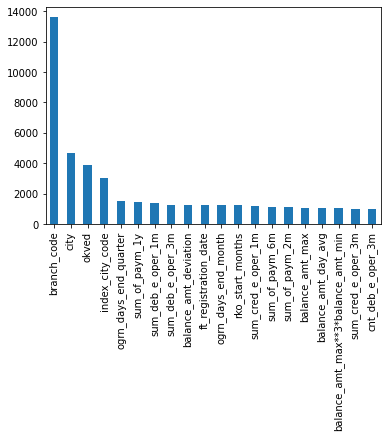

In [386]:
#!g1.2
plot_feature_importances(feature_importances, train_x.columns)

In [387]:
#!g1.2
train_x_en = train_x.fillna(-1)
val_x_en = val_x.fillna(-1)
test_en = test_df.fillna(-1)

In [388]:
#!g1.2
test_predictions_xgb, test_probablity_xgb, train_predictions, train_probablity, scores, feature_importances, result_zip = eval_xgboost(
    train_x_en,
    train_y,
    test_en,
    None,
    xgb_params,
    'xgboost_tts',
    (val_x_en, val_y)
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[09:52:51] WARNING: ../src/learner.cc:767: 
Parameters: { "device", "n_job" } are not used.

[0]	validation_0-auc:0.85623
[100]	validation_0-auc:0.91520
[200]	validation_0-auc:0.92887
[300]	validation_0-auc:0.93673
[400]	validation_0-auc:0.94191
[500]	validation_0-auc:0.94542
[600]	validation_0-auc:0.94827
[700]	validation_0-auc:0.95000
[800]	validation_0-auc:0.95161
[900]	validation_0-auc:0.95263
[999]	validation_0-auc:0.95351
------------------------------------------------------------


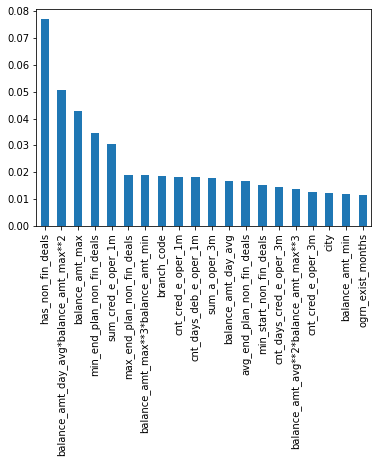

In [389]:
#!g1.2


plot_feature_importances(feature_importances, train_x_en.columns)


# Ансамбль


In [390]:
#!g1.2
def get_submission_df(predictions):
    sample_submission = pd.read_csv('sample_submission.csv')
    print(sample_submission.shape)
    sample_submission['score'] = predictions
    return sample_submission

def ensemble_predictions(preds):
    ensemble_prediction = np.zeros(preds[0].shape)
    for pred in preds:
        ensemble_prediction += pred
    ensemble_prediction /= len(preds)
    return get_submission_df(ensemble_prediction)


In [391]:
#!g1.2
ensemble_predictions([test_predictions_cat, test_predictions_lgb, test_predictions_xgb]).to_csv('my_submission_hz.csv', index=False)

(100000, 2)


In [ ]:
#!g1.2
